In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from model import DoubleMassSpringDamper

In [2]:
def isControlable(A, B):
    n = len(A)
    conMat = []
    for i in range(n):
        conMat.append(np.dot(np.linalg.matrix_power(A, i), B))
    #print('from isControllable: ', np.linalg.matrix_rank(np.array(conMat)))
    return np.linalg.matrix_rank(np.array(conMat).reshape(4,4)) == n

def isObservable(A, C):
    n = len(A)
    obsMat = []
    for i in range(n):
        obsMat.append(np.dot(C, np.linalg.matrix_power(A, i)))
    return np.linalg.matrix_rank(obsMat) == n

controllable:  True
<class 'numpy.ndarray'>


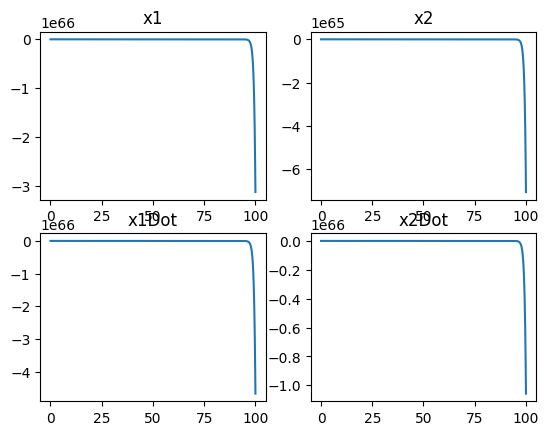

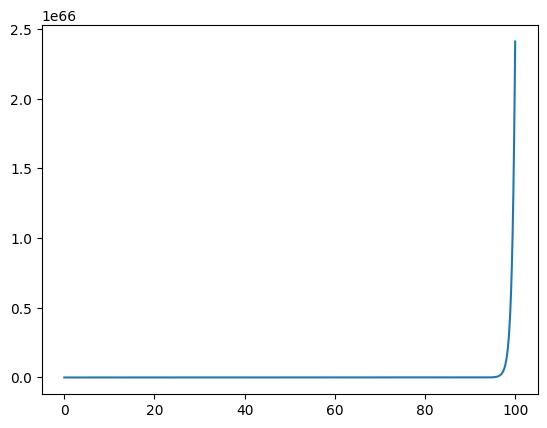

In [20]:
def main():
    m1 = 1
    m2 = 2
    c1 = 0.05
    c2 = 0.08
    k  = 1.2
    b = 0.1
    isDisturbance = True
    simTime = 100
    simDt = 0.01
    r = 10#reference to be tracked
    doubleMSD = DoubleMassSpringDamper(m1, m2, b, c1, c2, k, isDisturbance)

    print("controllable: ", isControlable(doubleMSD.AMat, doubleMSD.BMat))
   # print(isObservable(doubleMSD.AMat, doubleMSD.CMat))

    poles = np.array([-0.1, -0.05, -0.03, -0.04])
    print(type(doubleMSD.AMat))
    K_mat = sc.signal.place_poles(np.array(doubleMSD.AMat), np.array(doubleMSD.BMat).reshape(4,1), np.array(poles)).gain_matrix
    #print('heya',K_mat, K_mat.shape)
    #y0 = [0, 0, 0, 0]
    vel_ss = -doubleMSD.k*r/doubleMSD.c2
    y0 = [100, 102 + r, vel_ss, vel_ss]
    y = y0
    
    y_array = [y]
    time_array = [0]
    outErrorInt = 0
    kInt = 0.05
    theta1, theta2 = 0,0
    for time in np.arange(0, simTime, simDt):
        uncertContrib = doubleMSD.c1/doubleMSD.c2*theta2 - theta1
        u_ss = -doubleMSD.k*(1 + doubleMSD.c1/doubleMSD.c2)*r - uncertContrib
        
        yT = np.array([y[0], y[0] + r, vel_ss, vel_ss])
        outErrorInt += np.dot(doubleMSD.CMat, y) -  r
        u_int = outErrorInt*kInt
        u_sf = np.dot(K_mat, (yT - np.array(y)))
        u_tot = u_ss - np.dot(K_mat,   np.array(y) - yT) + u_int*0
        #print('y', y, 'yT', yT)
        #print('dyn', doubleMSD.DynSS(y, time, u_tot[0]))
        #print('u_sf', u_sf)
        y_next = doubleMSD.nextState(np.array(y), u_tot[0], simDt)
        y_array.append(y_next)
        #print((np.dot(doubleMSD.AMat, np.array(y).reshape(4,1)) + np.dot(doubleMSD.BMat,u_tot[0])))
        theta1 = (y_next[2] - y[2])/simDt - (np.dot(doubleMSD.AMat, y) + np.dot(doubleMSD.BMat,u_tot[0]))[2,0]
        theta2 = (y_next[3] - y[3])/simDt - (np.dot(doubleMSD.AMat, y) + np.dot(doubleMSD.BMat,u_tot[0]))[3,0]
        y = y_next
        time_array.append(time+simDt)

    y_array = np.array(y_array)
    plt.figure(1)
    ax1 = plt.subplot(2,2,1)
    ax1.plot(time_array, y_array[:,0])
    ax1.title.set_text('x1')
    ax2 = plt.subplot(2,2,2)
    ax2.plot(time_array, y_array[:,1])
    ax2.title.set_text('x2')
    ax3 = plt.subplot(2,2,3)
    ax3.plot(time_array[:], y_array[:,2])
    ax3.title.set_text('x1Dot')
    ax4 = plt.subplot(2,2,4)
    ax4.plot(time_array[:], y_array[:,3])
    ax4.title.set_text('x2Dot')
    plt.figure(2)
    plt.plot(time_array, y_array[:,1] - y_array[:,0])


if __name__ == '__main__':
    main()


In [4]:
from model import DoubleMassSpringDamper
doubleMSD1 = DoubleMassSpringDamper(1, 1,3, 3, 2, 1, True)
print(doubleMSD1.AMat)

[[ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [-1.  1. -6.  3.]
 [ 1. -1.  3. -5.]]
